# Imports:

In [ ]:
# Makes sure to reload modules when they change
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.amp import GradScaler, autocast
import joblib
from tqdm import tqdm
from PIL import Image, ImageOps
from src.ensemble import create_region_labels

# --- CUSTOM IMPORTS ---
from src.utils import extractCoordinates, aspect_crop, haversine_distance, plot_images_from_dataloader, setup_TensorBoard_writers, log_error_map
from src.dataset import GeolocalizationDataset
from src.models import *
from src.ensemble import *

torch.backends.cudnn.benchmark = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Image preprocessing:

In [18]:
# Setup paths
RAW_IMAGE_FOLDER = r"C:\Users\Tal Sch\Desktop\merged edited images"             # Use original images for GPS extraction
PROCESSED_IMAGE_FOLDER = r"data_processed_Ensemble" # Use processed images for training

if not os.path.exists(PROCESSED_IMAGE_FOLDER) or len(os.listdir(PROCESSED_IMAGE_FOLDER)) < 970:
    os.makedirs(PROCESSED_IMAGE_FOLDER, exist_ok=True)

    print("Starting Pre-processing...")
    files = [f for f in os.listdir(RAW_IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg'))]

    for filename in tqdm(files):
        src_path = os.path.join(RAW_IMAGE_FOLDER, filename)
        dst_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
        
        try:
            with Image.open(src_path) as img:
                img = ImageOps.exif_transpose(img)
                img = img.convert('RGB')
                img = aspect_crop(img) 
                img = img.resize((224, 224), Image.Resampling.LANCZOS)
                img.save(dst_path, quality=95)
        except Exception as e:
            print(f"Failed {filename}: {e}")
else:
    print("Pre-processed images already exist. Skipping preprocessing step.")

Starting Pre-processing...


100%|██████████| 1474/1474 [02:46<00:00,  8.84it/s]


# Data loading:

In [19]:
if __name__ == "__main__":

    SCALER_SAVE_PATH = 'coordinate_scaler.pkl'

    # --- 2. EXTRACTION PHASE ---
    processed_data = []

    for filename in os.listdir(RAW_IMAGE_FOLDER):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            raw_image_path = os.path.join(RAW_IMAGE_FOLDER, filename)
            processed__image_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
            
            # Check if the processed version actually exists
            if not os.path.exists(processed__image_path):
                continue
                
            # Extract coordinates from the ORIGINAL file
            coords = extractCoordinates(raw_image_path)
            
            if coords:
                processed_data.append({
                    'path': processed__image_path, 
                    'lat': coords[0], 
                    'lon': coords[1]
                })

    df = pd.DataFrame(processed_data)
    
    # Keep 20% of the data for validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # --- 3. SCALING PHASE ---
    # must fit on training data *only*
    scaler = MinMaxScaler()
    train_df[['lat', 'lon']] = scaler.fit_transform(train_df[['lat', 'lon']])
    val_df[['lat', 'lon']] = scaler.transform(val_df[['lat', 'lon']])

    joblib.dump(scaler, SCALER_SAVE_PATH)

Initializing train dataset...
Caching 1179 images in RAM...


100%|██████████| 1179/1179 [00:05<00:00, 231.65it/s]


Initializing validation dataset...
Caching 295 images in RAM...


100%|██████████| 295/295 [00:01<00:00, 236.25it/s]


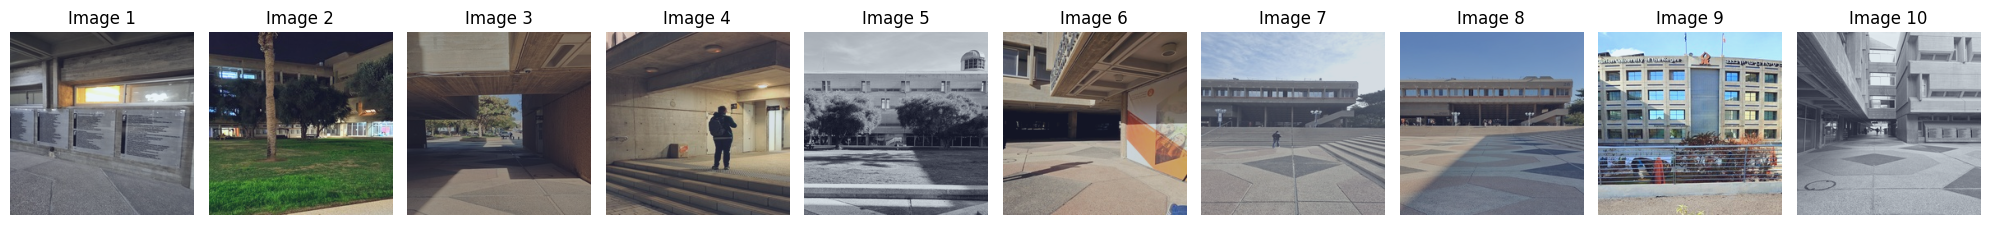

In [20]:
if __name__ == "__main__":

    # --- 4. DATASET INITIALIZATION ---
    print("Initializing train dataset...")
    train_dataset = GeolocalizationDataset(
        image_paths=train_df['path'].tolist(),
        coordinates=train_df[['lat', 'lon']].values,
        is_train=True
    )
    print("Initializing validation dataset...")
    val_dataset = GeolocalizationDataset(
        image_paths=val_df['path'].tolist(),
        coordinates=val_df[['lat', 'lon']].values,
        is_train=False
    )

    # --- 5. THE DATALOADER ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0, 
        pin_memory=True)
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0, 
        pin_memory=False)
    
    plot_images_from_dataloader(train_loader)

# Model setup:

In [21]:
# --- 6. INITIALIZE DEVICE & LOSS (Global Setup) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_rtx = "RTX" in torch.cuda.get_device_name(0)

print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    if is_rtx:
        print("⚡ RTX card detected: AMP & Channels_Last optimizations enabled.")
    else:
        print("Standard GPU detected.")

# Define the Loss Function globally (used by all ensemble models)
criterion = torch.nn.HuberLoss(delta=1.0)

print("✅ Device and Loss initialized. Ready for Ensemble Loop.")
# NOTE: Do NOT initialize 'model', 'optimizer', or 'scheduler' here.
# The Ensemble Loop in the next cell will handle that for each architecture.

# --- 7. LOSS & OPTIMIZER ---
patience_counter = 0
early_stopping_patience = 20
epochs = 100
use_TensorBoard = False 

print(f"Training on {len(train_dataset)} images...")

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
⚡ RTX card detected: AMP & Channels_Last optimizations enabled.
✅ Device and Loss initialized. Ready for Ensemble Loop.
Training on 1179 images...


# Model training:

In [22]:
# ============================================================================
# 🚀 FINAL ENSEMBLE TRAINING (Mixed Architectures: CLIP + DINOv2)
# ============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import datetime
from torch.utils.tensorboard import SummaryWriter

# 1. STORAGE FOR PLOTTING LATER
all_histories = {} 

# 2. DEFINE THE 3 MODELS (Heterogeneous Ensemble)
ensemble_configs = [

    # Model 1: CLIP Base Patch32 (The Generalist - KEEPER)
    {
        "type": "CLIP",
        "name": "openai/clip-vit-base-patch32",         
        "lr": 2e-3, 
        "save_as": "model_patch32.pth", 
        "run_name": "Run_Patch32"
    },


    # Model 2: DINOv2 Base (The "Newest DINO" - Semantic Expert)
    {
        "type": "DINO",
        "name": "facebook/dinov2-base",                 
        "lr": 2e-3,
        "save_as": "model_dinov2.pth", 
        "run_name": "Run_DINOv2"
    }

]

stored_models = []

print(f"🚀 STARTING ENSEMBLE TRAINING ({len(ensemble_configs)} Architectures)")

# --- OUTER LOOP: Iterate through architectures ---
for run_idx, config in enumerate(ensemble_configs):
    
    model_type = config['type']
    model_name = config['name']
    save_path = config['save_as']
    run_name = config['run_name']
    
    print(f"\n" + "="*60)
    print(f"🎬 TRAINING MODEL {run_idx+1}/{len(ensemble_configs)}: {model_type} ({model_name})")
    print("="*60)

    # A. Initialize Specific Model Class
    if model_type == "CLIP":
        model = GeoCLIP(dropout_rate=0.2, model_name=model_name).to(device)
    elif model_type == "DINO":
        model = GeoDINO(dropout_rate=0.3, model_name=model_name).to(device)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=config['lr'],
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3  # 30% warmup
    )
        
    elif model_type == "ConvNeXt":
        model = GeoConvNeXt(dropout_rate=0.5, model_name=model_name).to(device)
    
    if is_rtx: model = model.to(memory_format=torch.channels_last)
    
    # B. Setup Optimizer
    # Initial setup: Head is likely the only thing unfrozen by default in your classes
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=config['lr'], 
        weight_decay=0.05
    )
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    gradScaler = GradScaler('cuda')
    
    # C. Reset Metrics for this run
    train_losses, val_losses, val_dist_history = [], [], []
    best_dist = float("inf")
    patience_counter = 0
    
    # D. TensorBoard
    if use_TensorBoard:
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        writer_train = SummaryWriter(log_dir=f'runs/{run_name}_{current_time}/train')
        writer_val   = SummaryWriter(log_dir=f'runs/{run_name}_{current_time}/val')

    # --- INNER LOOP: Epochs ---
    for epoch in range(epochs):
        
        # === STAGE 2: UNFREEZE LAST 2 LAYERS (Epoch 10) ===
        if epoch == 10:
            print(f"\n>>> UNFREEZING LAST 2 LAYERS ({model_type}) <<<")
            model.unfreeze_last_layers(num_layers=2)
            
            # Re-initialize optimizer to catch newly unfrozen parameters
            # We use a generic filter because ResNet/ViT/DINO have different internal names
            optimizer = torch.optim.AdamW(
                filter(lambda p: p.requires_grad, model.parameters()), 
                lr=config['lr'] * 0.1, # Drop LR for fine-tuning
                weight_decay=0.01
            )
            
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs-epoch, eta_min=1e-6)
            patience_counter = 0 

        # === STAGE 3: UNFREEZE LAST 4 LAYERS (Epoch 25) ===
        if epoch == 25:
            print(f"\n>>> UNFREEZING LAST 4 LAYERS ({model_type}) <<<")
            model.unfreeze_last_layers(num_layers=4)
            
            optimizer = torch.optim.AdamW(
                filter(lambda p: p.requires_grad, model.parameters()), 
                lr=config['lr'] * 0.05,
                weight_decay=0.01
            )
            
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs-epoch, eta_min=1e-7)
            patience_counter = 0

        # --- PHASE 1: TRAINING ---
        model.train()
        train_running_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False, unit="batch")
        
        for images, labels, *args in pbar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            if is_rtx: images = images.to(memory_format=torch.channels_last)

            optimizer.zero_grad(set_to_none=True)

            if is_rtx:
                with autocast('cuda', dtype=torch.float16):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                gradScaler.scale(loss).backward() 
                gradScaler.step(optimizer)        
                gradScaler.update()  
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            train_running_loss += loss.item()

        # --- PHASE 2: VALIDATION ---
        model.eval()
        val_running_loss = 0.0
        raw_preds, raw_trues = [], []

        with torch.no_grad():
            for images, labels, *args in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = model(images) 
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                raw_preds.append(outputs.cpu().numpy())
                raw_trues.append(labels.cpu().numpy())

        # --- PHASE 3: METRICS ---
        real_preds = scaler.inverse_transform(np.vstack(raw_preds))
        real_trues = scaler.inverse_transform(np.vstack(raw_trues))
        distances = haversine_distance(real_preds, real_trues)
        avg_dist_error = np.mean(distances)
        
        avg_train_loss = train_running_loss / len(train_loader)
        avg_val_loss = val_running_loss / len(val_loader)

        if use_TensorBoard:
            writer_train.add_scalar('Total Loss', avg_train_loss, epoch)
            writer_val.add_scalar('Total Loss', avg_val_loss, epoch)
            writer_val.add_scalar('Distance Error (m)', avg_dist_error, epoch)
        else:
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            val_dist_history.append(avg_dist_error)

        print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f} | Val Loss {avg_val_loss:.4f} | Error {avg_dist_error:.1f}m | Patience {patience_counter}/{early_stopping_patience}")
        scheduler.step()

        # --- SAVE BEST ---
        if avg_dist_error < best_dist:
            best_dist = avg_dist_error
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"   *** NEW BEST: {best_dist:.1f}m ***")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"⏹ Early stopping for {model_name}.")
                break
                
    if use_TensorBoard:
        writer_train.close()
        writer_val.close()
        
    # === HISTORY SAVING ===
    all_histories[model_name] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'dist_error': val_dist_history,
        'best_dist': best_dist
    }
    
    print(f"✅ Finished {model_name}. Best Error: {best_dist:.2f}m. Saved to {save_path}")
    stored_models.append(save_path)

print("\n🏆 ENSEMBLE TRAINING COMPLETE.")

🚀 STARTING ENSEMBLE TRAINING (2 Architectures)

🎬 TRAINING MODEL 1/2: CLIP (openai/clip-vit-base-patch32)
Loading openai/clip-vit-base-patch32...


Epoch 1: Train Loss 0.1427 | Val Loss 0.0342 | Error 76.0m | Patience 0/20
   *** NEW BEST: 76.0m ***


Epoch 2: Train Loss 0.0325 | Val Loss 0.0229 | Error 57.0m | Patience 0/20
   *** NEW BEST: 57.0m ***


Epoch 3: Train Loss 0.0256 | Val Loss 0.0244 | Error 49.7m | Patience 0/20
   *** NEW BEST: 49.7m ***


Epoch 4: Train Loss 0.0238 | Val Loss 0.0167 | Error 46.3m | Patience 0/20
   *** NEW BEST: 46.3m ***


Epoch 5: Train Loss 0.0200 | Val Loss 0.0169 | Error 43.0m | Patience 0/20
   *** NEW BEST: 43.0m ***


Epoch 6: Train Loss 0.0174 | Val Loss 0.0139 | Error 41.7m | Patience 0/20
   *** NEW BEST: 41.7m ***


Epoch 7: Train Loss 0.0163 | Val Loss 0.0155 | Error 46.9m | Patience 0/20


Epoch 8: Train Loss 0.0146 | Val Loss 0.0123 | Error 37.6m | Patience 1/20
   *** NEW BEST: 37.6m ***


Epoch 9: Train Loss 0.0139 | Val Loss 0.0126 | Error 38.6m | Patience 0/20


Epoch 10: Train Loss 0.0124 | Val Loss 0.0119 | Error 35.9m | Patience 1/20
   *** NEW BEST: 35.9m ***

>>> UNFREEZING LAST 2 LAYERS (CLIP) <<<
🔓 Unfreezing last 2 layers for CLIP...


Epoch 11: Train Loss 0.0298 | Val Loss 0.0136 | Error 41.5m | Patience 0/20


Epoch 12: Train Loss 0.0116 | Val Loss 0.0091 | Error 33.2m | Patience 1/20
   *** NEW BEST: 33.2m ***


Epoch 13: Train Loss 0.0068 | Val Loss 0.0072 | Error 26.0m | Patience 0/20
   *** NEW BEST: 26.0m ***


Epoch 14: Train Loss 0.0054 | Val Loss 0.0079 | Error 26.8m | Patience 0/20


Epoch 15: Train Loss 0.0044 | Val Loss 0.0071 | Error 26.8m | Patience 1/20


Epoch 16: Train Loss 0.0037 | Val Loss 0.0065 | Error 23.5m | Patience 2/20
   *** NEW BEST: 23.5m ***


Epoch 17: Train Loss 0.0029 | Val Loss 0.0062 | Error 25.3m | Patience 0/20


Epoch 18: Train Loss 0.0024 | Val Loss 0.0062 | Error 23.7m | Patience 1/20


Epoch 19: Train Loss 0.0025 | Val Loss 0.0063 | Error 23.6m | Patience 2/20


Epoch 20: Train Loss 0.0025 | Val Loss 0.0053 | Error 21.8m | Patience 3/20
   *** NEW BEST: 21.8m ***


Epoch 21: Train Loss 0.0019 | Val Loss 0.0056 | Error 21.0m | Patience 0/20
   *** NEW BEST: 21.0m ***


Epoch 22: Train Loss 0.0017 | Val Loss 0.0053 | Error 22.2m | Patience 0/20


Epoch 23: Train Loss 0.0016 | Val Loss 0.0051 | Error 20.7m | Patience 1/20
   *** NEW BEST: 20.7m ***


Epoch 24: Train Loss 0.0017 | Val Loss 0.0056 | Error 20.5m | Patience 0/20
   *** NEW BEST: 20.5m ***


Epoch 25: Train Loss 0.0016 | Val Loss 0.0056 | Error 23.0m | Patience 0/20

>>> UNFREEZING LAST 4 LAYERS (CLIP) <<<
🔓 Unfreezing last 4 layers for CLIP...


Epoch 26: Train Loss 0.0086 | Val Loss 0.0075 | Error 26.0m | Patience 0/20


Epoch 27: Train Loss 0.0028 | Val Loss 0.0052 | Error 20.3m | Patience 1/20
   *** NEW BEST: 20.3m ***


Epoch 28: Train Loss 0.0022 | Val Loss 0.0052 | Error 20.9m | Patience 0/20


Epoch 29: Train Loss 0.0021 | Val Loss 0.0053 | Error 20.5m | Patience 1/20


Epoch 30: Train Loss 0.0018 | Val Loss 0.0049 | Error 19.9m | Patience 2/20
   *** NEW BEST: 19.9m ***


Epoch 31: Train Loss 0.0015 | Val Loss 0.0050 | Error 19.1m | Patience 0/20
   *** NEW BEST: 19.1m ***


Epoch 32: Train Loss 0.0015 | Val Loss 0.0045 | Error 19.4m | Patience 0/20


Epoch 33: Train Loss 0.0015 | Val Loss 0.0062 | Error 19.0m | Patience 1/20
   *** NEW BEST: 19.0m ***


Epoch 34: Train Loss 0.0016 | Val Loss 0.0049 | Error 18.9m | Patience 0/20
   *** NEW BEST: 18.9m ***


Epoch 35: Train Loss 0.0018 | Val Loss 0.0045 | Error 18.0m | Patience 0/20
   *** NEW BEST: 18.0m ***


Epoch 36: Train Loss 0.0014 | Val Loss 0.0048 | Error 18.3m | Patience 0/20


Epoch 37: Train Loss 0.0014 | Val Loss 0.0049 | Error 18.6m | Patience 1/20


Epoch 38: Train Loss 0.0013 | Val Loss 0.0046 | Error 18.6m | Patience 2/20


Epoch 39: Train Loss 0.0011 | Val Loss 0.0046 | Error 17.5m | Patience 3/20
   *** NEW BEST: 17.5m ***


Epoch 40: Train Loss 0.0012 | Val Loss 0.0042 | Error 17.8m | Patience 0/20


Epoch 41: Train Loss 0.0013 | Val Loss 0.0042 | Error 17.7m | Patience 1/20


Epoch 42: Train Loss 0.0011 | Val Loss 0.0039 | Error 16.6m | Patience 2/20
   *** NEW BEST: 16.6m ***


Epoch 43: Train Loss 0.0011 | Val Loss 0.0045 | Error 17.7m | Patience 0/20


Epoch 44: Train Loss 0.0010 | Val Loss 0.0039 | Error 17.2m | Patience 1/20


Epoch 45: Train Loss 0.0009 | Val Loss 0.0039 | Error 16.9m | Patience 2/20


Epoch 46: Train Loss 0.0009 | Val Loss 0.0040 | Error 16.8m | Patience 3/20


Epoch 47: Train Loss 0.0009 | Val Loss 0.0047 | Error 16.8m | Patience 4/20


Epoch 48: Train Loss 0.0009 | Val Loss 0.0039 | Error 16.6m | Patience 5/20
   *** NEW BEST: 16.6m ***


Epoch 49: Train Loss 0.0008 | Val Loss 0.0038 | Error 16.7m | Patience 0/20


Epoch 50: Train Loss 0.0008 | Val Loss 0.0046 | Error 18.0m | Patience 1/20


Epoch 51: Train Loss 0.0009 | Val Loss 0.0039 | Error 17.0m | Patience 2/20


Epoch 52: Train Loss 0.0008 | Val Loss 0.0041 | Error 16.8m | Patience 3/20


Epoch 53: Train Loss 0.0008 | Val Loss 0.0044 | Error 16.9m | Patience 4/20


Epoch 54: Train Loss 0.0008 | Val Loss 0.0038 | Error 16.7m | Patience 5/20


Epoch 55: Train Loss 0.0007 | Val Loss 0.0040 | Error 16.2m | Patience 6/20
   *** NEW BEST: 16.2m ***


Epoch 56: Train Loss 0.0007 | Val Loss 0.0038 | Error 15.8m | Patience 0/20
   *** NEW BEST: 15.8m ***


Epoch 57: Train Loss 0.0006 | Val Loss 0.0039 | Error 15.9m | Patience 0/20


Epoch 58: Train Loss 0.0007 | Val Loss 0.0042 | Error 16.1m | Patience 1/20


Epoch 59: Train Loss 0.0006 | Val Loss 0.0036 | Error 16.2m | Patience 2/20


Epoch 60: Train Loss 0.0006 | Val Loss 0.0040 | Error 16.0m | Patience 3/20


Epoch 61: Train Loss 0.0006 | Val Loss 0.0038 | Error 16.1m | Patience 4/20


Epoch 62: Train Loss 0.0007 | Val Loss 0.0037 | Error 15.7m | Patience 5/20
   *** NEW BEST: 15.7m ***


Epoch 63: Train Loss 0.0006 | Val Loss 0.0038 | Error 15.7m | Patience 0/20


Epoch 64: Train Loss 0.0006 | Val Loss 0.0039 | Error 15.6m | Patience 1/20
   *** NEW BEST: 15.6m ***


Epoch 65: Train Loss 0.0006 | Val Loss 0.0037 | Error 15.7m | Patience 0/20


Epoch 66: Train Loss 0.0006 | Val Loss 0.0042 | Error 15.9m | Patience 1/20


Epoch 67: Train Loss 0.0006 | Val Loss 0.0042 | Error 16.1m | Patience 2/20


Epoch 68: Train Loss 0.0006 | Val Loss 0.0038 | Error 15.8m | Patience 3/20


Epoch 69: Train Loss 0.0006 | Val Loss 0.0039 | Error 15.7m | Patience 4/20


Epoch 70: Train Loss 0.0006 | Val Loss 0.0037 | Error 16.4m | Patience 5/20


Epoch 71: Train Loss 0.0005 | Val Loss 0.0036 | Error 15.5m | Patience 6/20
   *** NEW BEST: 15.5m ***


Epoch 72: Train Loss 0.0006 | Val Loss 0.0038 | Error 15.9m | Patience 0/20


Epoch 73: Train Loss 0.0005 | Val Loss 0.0037 | Error 15.9m | Patience 1/20


Epoch 74: Train Loss 0.0005 | Val Loss 0.0036 | Error 15.3m | Patience 2/20
   *** NEW BEST: 15.3m ***


Epoch 75: Train Loss 0.0005 | Val Loss 0.0036 | Error 15.7m | Patience 0/20


Epoch 76: Train Loss 0.0005 | Val Loss 0.0035 | Error 15.4m | Patience 1/20


Epoch 77: Train Loss 0.0005 | Val Loss 0.0037 | Error 15.6m | Patience 2/20


Epoch 78: Train Loss 0.0005 | Val Loss 0.0035 | Error 15.6m | Patience 3/20


Epoch 79: Train Loss 0.0005 | Val Loss 0.0036 | Error 15.5m | Patience 4/20


Epoch 80: Train Loss 0.0005 | Val Loss 0.0036 | Error 15.7m | Patience 5/20


Epoch 81: Train Loss 0.0005 | Val Loss 0.0036 | Error 15.6m | Patience 6/20


Epoch 82: Train Loss 0.0005 | Val Loss 0.0035 | Error 15.5m | Patience 7/20


Epoch 83: Train Loss 0.0005 | Val Loss 0.0034 | Error 15.6m | Patience 8/20


Epoch 84: Train Loss 0.0005 | Val Loss 0.0034 | Error 15.5m | Patience 9/20


Epoch 85: Train Loss 0.0005 | Val Loss 0.0035 | Error 15.5m | Patience 10/20


Epoch 86: Train Loss 0.0005 | Val Loss 0.0035 | Error 15.4m | Patience 11/20


Epoch 87: Train Loss 0.0004 | Val Loss 0.0035 | Error 15.3m | Patience 12/20


Epoch 88: Train Loss 0.0005 | Val Loss 0.0035 | Error 15.4m | Patience 13/20


Epoch 89: Train Loss 0.0005 | Val Loss 0.0035 | Error 15.4m | Patience 14/20


Epoch 90: Train Loss 0.0004 | Val Loss 0.0035 | Error 15.5m | Patience 15/20


Epoch 91: Train Loss 0.0004 | Val Loss 0.0035 | Error 15.4m | Patience 16/20


Epoch 92: Train Loss 0.0005 | Val Loss 0.0035 | Error 15.4m | Patience 17/20


Epoch 93: Train Loss 0.0004 | Val Loss 0.0035 | Error 15.5m | Patience 18/20


Epoch 94: Train Loss 0.0005 | Val Loss 0.0035 | Error 15.4m | Patience 19/20
⏹ Early stopping for openai/clip-vit-base-patch32.
✅ Finished openai/clip-vit-base-patch32. Best Error: 15.32m. Saved to model_patch32.pth

🎬 TRAINING MODEL 2/2: DINO (facebook/dinov2-base)
Loading DINOv2 Backbone: facebook/dinov2-base...


Epoch 1: Train Loss 0.1114 | Val Loss 0.0186 | Error 47.0m | Patience 0/20
   *** NEW BEST: 47.0m ***


Epoch 2: Train Loss 0.0222 | Val Loss 0.0154 | Error 41.0m | Patience 0/20
   *** NEW BEST: 41.0m ***


Epoch 3: Train Loss 0.0185 | Val Loss 0.0143 | Error 37.2m | Patience 0/20
   *** NEW BEST: 37.2m ***


Epoch 4: Train Loss 0.0157 | Val Loss 0.0132 | Error 34.4m | Patience 0/20
   *** NEW BEST: 34.4m ***


Epoch 5: Train Loss 0.0143 | Val Loss 0.0105 | Error 31.4m | Patience 0/20
   *** NEW BEST: 31.4m ***


Epoch 6: Train Loss 0.0113 | Val Loss 0.0099 | Error 30.2m | Patience 0/20
   *** NEW BEST: 30.2m ***


Epoch 7: Train Loss 0.0101 | Val Loss 0.0092 | Error 28.5m | Patience 0/20
   *** NEW BEST: 28.5m ***


Epoch 8: Train Loss 0.0099 | Val Loss 0.0106 | Error 31.0m | Patience 0/20


Epoch 9: Train Loss 0.0088 | Val Loss 0.0092 | Error 27.6m | Patience 1/20
   *** NEW BEST: 27.6m ***


Epoch 10: Train Loss 0.0076 | Val Loss 0.0083 | Error 27.0m | Patience 0/20
   *** NEW BEST: 27.0m ***

>>> UNFREEZING LAST 2 LAYERS (DINO) <<<
🔓 Unfreezing last 2 layers for DINOv2...


Epoch 11: Train Loss 0.0416 | Val Loss 0.0194 | Error 47.0m | Patience 0/20


Epoch 12: Train Loss 0.0177 | Val Loss 0.0132 | Error 32.3m | Patience 1/20


Epoch 13: Train Loss 0.0125 | Val Loss 0.0111 | Error 28.2m | Patience 2/20


Epoch 14: Train Loss 0.0089 | Val Loss 0.0076 | Error 24.5m | Patience 3/20
   *** NEW BEST: 24.5m ***


Epoch 15: Train Loss 0.0056 | Val Loss 0.0066 | Error 22.9m | Patience 0/20
   *** NEW BEST: 22.9m ***


Epoch 16: Train Loss 0.0042 | Val Loss 0.0056 | Error 23.1m | Patience 0/20


Epoch 17: Train Loss 0.0033 | Val Loss 0.0055 | Error 21.0m | Patience 1/20
   *** NEW BEST: 21.0m ***


Epoch 18: Train Loss 0.0027 | Val Loss 0.0049 | Error 20.7m | Patience 0/20
   *** NEW BEST: 20.7m ***


Epoch 19: Train Loss 0.0023 | Val Loss 0.0049 | Error 20.4m | Patience 0/20
   *** NEW BEST: 20.4m ***


Epoch 20: Train Loss 0.0022 | Val Loss 0.0043 | Error 18.9m | Patience 0/20
   *** NEW BEST: 18.9m ***


Epoch 21: Train Loss 0.0020 | Val Loss 0.0047 | Error 19.1m | Patience 0/20


Epoch 22: Train Loss 0.0019 | Val Loss 0.0046 | Error 19.0m | Patience 1/20


Epoch 23: Train Loss 0.0019 | Val Loss 0.0045 | Error 17.9m | Patience 2/20
   *** NEW BEST: 17.9m ***


Epoch 24: Train Loss 0.0018 | Val Loss 0.0041 | Error 19.0m | Patience 0/20


Epoch 25: Train Loss 0.0017 | Val Loss 0.0042 | Error 18.3m | Patience 1/20

>>> UNFREEZING LAST 4 LAYERS (DINO) <<<
🔓 Unfreezing last 4 layers for DINOv2...


Epoch 26: Train Loss 0.0128 | Val Loss 0.0076 | Error 24.2m | Patience 0/20


Epoch 27: Train Loss 0.0053 | Val Loss 0.0047 | Error 19.9m | Patience 1/20


Epoch 28: Train Loss 0.0029 | Val Loss 0.0046 | Error 20.1m | Patience 2/20


Epoch 29: Train Loss 0.0024 | Val Loss 0.0040 | Error 18.2m | Patience 3/20


Epoch 30: Train Loss 0.0022 | Val Loss 0.0039 | Error 17.9m | Patience 4/20
   *** NEW BEST: 17.9m ***


Epoch 31: Train Loss 0.0017 | Val Loss 0.0042 | Error 17.0m | Patience 0/20
   *** NEW BEST: 17.0m ***


Epoch 32: Train Loss 0.0020 | Val Loss 0.0044 | Error 17.4m | Patience 0/20


Epoch 33: Train Loss 0.0017 | Val Loss 0.0038 | Error 17.0m | Patience 1/20


Epoch 34: Train Loss 0.0015 | Val Loss 0.0036 | Error 17.5m | Patience 2/20


Epoch 35: Train Loss 0.0014 | Val Loss 0.0040 | Error 18.1m | Patience 3/20


Epoch 36: Train Loss 0.0015 | Val Loss 0.0038 | Error 16.5m | Patience 4/20
   *** NEW BEST: 16.5m ***


Epoch 37: Train Loss 0.0014 | Val Loss 0.0034 | Error 16.3m | Patience 0/20
   *** NEW BEST: 16.3m ***


Epoch 38: Train Loss 0.0013 | Val Loss 0.0037 | Error 16.5m | Patience 0/20


Epoch 39: Train Loss 0.0012 | Val Loss 0.0037 | Error 15.8m | Patience 1/20
   *** NEW BEST: 15.8m ***


Epoch 40: Train Loss 0.0012 | Val Loss 0.0037 | Error 16.2m | Patience 0/20


Epoch 41: Train Loss 0.0012 | Val Loss 0.0033 | Error 15.8m | Patience 1/20
   *** NEW BEST: 15.8m ***


Epoch 42: Train Loss 0.0011 | Val Loss 0.0035 | Error 16.0m | Patience 0/20


Epoch 43: Train Loss 0.0012 | Val Loss 0.0033 | Error 15.3m | Patience 1/20
   *** NEW BEST: 15.3m ***


Epoch 44: Train Loss 0.0012 | Val Loss 0.0036 | Error 16.8m | Patience 0/20


Epoch 45: Train Loss 0.0011 | Val Loss 0.0034 | Error 15.7m | Patience 1/20


Epoch 46: Train Loss 0.0010 | Val Loss 0.0032 | Error 15.6m | Patience 2/20


Epoch 47: Train Loss 0.0010 | Val Loss 0.0033 | Error 15.8m | Patience 3/20


Epoch 48: Train Loss 0.0011 | Val Loss 0.0034 | Error 16.4m | Patience 4/20


Epoch 49: Train Loss 0.0010 | Val Loss 0.0034 | Error 15.4m | Patience 5/20


Epoch 50: Train Loss 0.0009 | Val Loss 0.0035 | Error 15.6m | Patience 6/20


Epoch 51: Train Loss 0.0010 | Val Loss 0.0034 | Error 15.5m | Patience 7/20


Epoch 52: Train Loss 0.0010 | Val Loss 0.0041 | Error 17.1m | Patience 8/20


Epoch 53: Train Loss 0.0010 | Val Loss 0.0031 | Error 15.0m | Patience 9/20
   *** NEW BEST: 15.0m ***


Epoch 54: Train Loss 0.0009 | Val Loss 0.0033 | Error 15.3m | Patience 0/20


Epoch 55: Train Loss 0.0010 | Val Loss 0.0032 | Error 14.9m | Patience 1/20
   *** NEW BEST: 14.9m ***


Epoch 56: Train Loss 0.0009 | Val Loss 0.0032 | Error 15.3m | Patience 0/20


Epoch 57: Train Loss 0.0009 | Val Loss 0.0036 | Error 15.4m | Patience 1/20


Epoch 58: Train Loss 0.0008 | Val Loss 0.0033 | Error 16.1m | Patience 2/20


Epoch 59: Train Loss 0.0008 | Val Loss 0.0033 | Error 15.1m | Patience 3/20


Epoch 60: Train Loss 0.0008 | Val Loss 0.0033 | Error 15.2m | Patience 4/20


Epoch 61: Train Loss 0.0008 | Val Loss 0.0032 | Error 15.3m | Patience 5/20


Epoch 62: Train Loss 0.0008 | Val Loss 0.0032 | Error 14.8m | Patience 6/20
   *** NEW BEST: 14.8m ***


Epoch 63: Train Loss 0.0008 | Val Loss 0.0031 | Error 15.4m | Patience 0/20


Epoch 64: Train Loss 0.0008 | Val Loss 0.0031 | Error 15.2m | Patience 1/20


Epoch 65: Train Loss 0.0008 | Val Loss 0.0031 | Error 14.7m | Patience 2/20
   *** NEW BEST: 14.7m ***


Epoch 66: Train Loss 0.0008 | Val Loss 0.0033 | Error 15.1m | Patience 0/20


Epoch 67: Train Loss 0.0008 | Val Loss 0.0031 | Error 14.7m | Patience 1/20


Epoch 68: Train Loss 0.0007 | Val Loss 0.0031 | Error 14.5m | Patience 2/20
   *** NEW BEST: 14.5m ***


Epoch 69: Train Loss 0.0008 | Val Loss 0.0032 | Error 14.6m | Patience 0/20


Epoch 70: Train Loss 0.0007 | Val Loss 0.0032 | Error 14.8m | Patience 1/20


Epoch 71: Train Loss 0.0007 | Val Loss 0.0031 | Error 14.6m | Patience 2/20


Epoch 72: Train Loss 0.0007 | Val Loss 0.0032 | Error 14.6m | Patience 3/20


Epoch 73: Train Loss 0.0007 | Val Loss 0.0031 | Error 14.5m | Patience 4/20
   *** NEW BEST: 14.5m ***


Epoch 74: Train Loss 0.0007 | Val Loss 0.0032 | Error 14.7m | Patience 0/20


Epoch 75: Train Loss 0.0007 | Val Loss 0.0033 | Error 14.8m | Patience 1/20


Epoch 76: Train Loss 0.0007 | Val Loss 0.0032 | Error 14.7m | Patience 2/20


Epoch 77: Train Loss 0.0007 | Val Loss 0.0031 | Error 14.5m | Patience 3/20
   *** NEW BEST: 14.5m ***


Epoch 78: Train Loss 0.0007 | Val Loss 0.0031 | Error 14.5m | Patience 0/20


Epoch 79: Train Loss 0.0007 | Val Loss 0.0031 | Error 14.2m | Patience 1/20
   *** NEW BEST: 14.2m ***


Epoch 80: Train Loss 0.0007 | Val Loss 0.0031 | Error 14.2m | Patience 0/20
   *** NEW BEST: 14.2m ***


Epoch 81: Train Loss 0.0007 | Val Loss 0.0031 | Error 14.1m | Patience 0/20
   *** NEW BEST: 14.1m ***


Epoch 82: Train Loss 0.0007 | Val Loss 0.0031 | Error 14.0m | Patience 0/20
   *** NEW BEST: 14.0m ***


Epoch 83: Train Loss 0.0007 | Val Loss 0.0030 | Error 13.9m | Patience 0/20
   *** NEW BEST: 13.9m ***


Epoch 84: Train Loss 0.0006 | Val Loss 0.0030 | Error 14.3m | Patience 0/20


Epoch 85: Train Loss 0.0007 | Val Loss 0.0030 | Error 14.1m | Patience 1/20


Epoch 86: Train Loss 0.0007 | Val Loss 0.0029 | Error 14.0m | Patience 2/20


Epoch 87: Train Loss 0.0006 | Val Loss 0.0030 | Error 14.2m | Patience 3/20


Epoch 88: Train Loss 0.0006 | Val Loss 0.0030 | Error 14.2m | Patience 4/20


Epoch 89: Train Loss 0.0006 | Val Loss 0.0030 | Error 14.2m | Patience 5/20


Epoch 90: Train Loss 0.0007 | Val Loss 0.0030 | Error 14.1m | Patience 6/20


Epoch 91: Train Loss 0.0006 | Val Loss 0.0030 | Error 14.2m | Patience 7/20


Epoch 92: Train Loss 0.0007 | Val Loss 0.0030 | Error 14.1m | Patience 8/20


Epoch 93: Train Loss 0.0006 | Val Loss 0.0030 | Error 14.1m | Patience 9/20


Epoch 94: Train Loss 0.0006 | Val Loss 0.0030 | Error 14.2m | Patience 10/20


Epoch 95: Train Loss 0.0007 | Val Loss 0.0030 | Error 14.2m | Patience 11/20


Epoch 96: Train Loss 0.0007 | Val Loss 0.0030 | Error 14.2m | Patience 12/20


Epoch 97: Train Loss 0.0007 | Val Loss 0.0030 | Error 14.2m | Patience 13/20


Epoch 98: Train Loss 0.0007 | Val Loss 0.0030 | Error 14.2m | Patience 14/20


Epoch 99: Train Loss 0.0006 | Val Loss 0.0030 | Error 14.2m | Patience 15/20


Epoch 100: Train Loss 0.0007 | Val Loss 0.0030 | Error 14.2m | Patience 16/20
✅ Finished facebook/dinov2-base. Best Error: 13.92m. Saved to model_dinov2.pth

🏆 ENSEMBLE TRAINING COMPLETE.


In [23]:
# ============================================================================
# 🤖 AUTOMATIC WEIGHT CALCULATION & INFERENCE
# ============================================================================
import numpy as np

# 1. Define the Config (DINO + CLIP)
my_models = [
    # Model 1: CLIP
    {
        'type': 'CLIP', 
        'path': 'model_patch32.pth', 
        'name': 'openai/clip-vit-base-patch32',
        'dropout': 0.2 
    },
    
    # Model 2: DINOv2
    {
        'type': 'DINO', 
        'path': 'model_dinov2.pth', 
        'name': 'facebook/dinov2-base',
        'dropout': 0.3 
    }
]

# 2. Extract Errors Automatically from 'all_histories'
print("\n🧮 Auto-Calculating Weights from Training History...")
extracted_errors = []

for config in my_models:
    name = config['name']
    
    # Check if we have history for this model
    if name in all_histories:
        best_err = all_histories[name]['best_dist']
        print(f"   Found {name}: Best Error = {best_err:.2f}m")
        extracted_errors.append(best_err)
    else:
        # Fallback if you restarted the kernel and lost 'all_histories'
        # (This prevents a crash, but warns you)
        print(f"   ⚠️ WARNING: No history found for {name}. Using placeholder 20.0m.")
        extracted_errors.append(20.0)

# 3. Compute Inverse Weights
errors_arr = np.array(extracted_errors, dtype=np.float32)
weights = 1.0 / (errors_arr + 1e-6)
ensemble_weights = weights / weights.sum()

print("-" * 40)
print("📊 FINAL WEIGHTS:")
for i, config in enumerate(my_models):
    print(f"   {config['type']}: {ensemble_weights[i]:.3f}")
print("-" * 40)

# 4. Initialize Ensemble with Auto-Weights
ensemble = GeoEnsemble(my_models, device=device, weights=ensemble_weights)

# 5. Run Prediction
print("\nRunning Weighted Inference...")
val_preds = []
val_trues = []

from tqdm import tqdm
loader_iter = tqdm(val_loader, desc="Inference", leave=True)

for images, labels, *args in loader_iter:
    images = images.to(device)
    if is_rtx: images = images.to(memory_format=torch.channels_last)

    batch_preds = ensemble.predict(images)

    val_preds.append(batch_preds.cpu().float().numpy())
    val_trues.append(labels.numpy())

# 6. Final Results
flat_preds = np.vstack(val_preds)
flat_trues = np.vstack(val_trues)
real_preds = scaler.inverse_transform(flat_preds)
real_trues = scaler.inverse_transform(flat_trues)
errors = haversine_distance(real_preds, real_trues)

print(f"\n✅ FINAL AUTOMATED RESULTS:")
print(f"Mean Error:   {np.mean(errors):.2f} meters")
print(f"Median Error: {np.median(errors):.2f} meters")
print(f"Worst Error:  {np.max(errors):.2f} meters")


🧮 Auto-Calculating Weights from Training History...
   Found openai/clip-vit-base-patch32: Best Error = 15.32m
   Found facebook/dinov2-base: Best Error = 13.92m
----------------------------------------
📊 FINAL WEIGHTS:
   CLIP: 0.476
   DINO: 0.524
----------------------------------------
⚖️ Ensemble Weights Set: [0.47592226 0.5240777 ]
🧩 Initializing Ensemble with 2 models...
Loading openai/clip-vit-base-patch32...
   -> Loading CLIP (Drop=0.2) from model_patch32.pth...
Loading DINOv2 Backbone: facebook/dinov2-base...
   -> Loading DINO (Drop=0.3) from model_dinov2.pth...

Running Weighted Inference...


Inference: 100%|██████████| 10/10 [00:01<00:00,  7.52it/s]


✅ FINAL AUTOMATED RESULTS:
Mean Error:   13.68 meters
Median Error: 10.66 meters
Worst Error:  61.70 meters


# Plotting the results:

📈 Generating plots for 2 models...


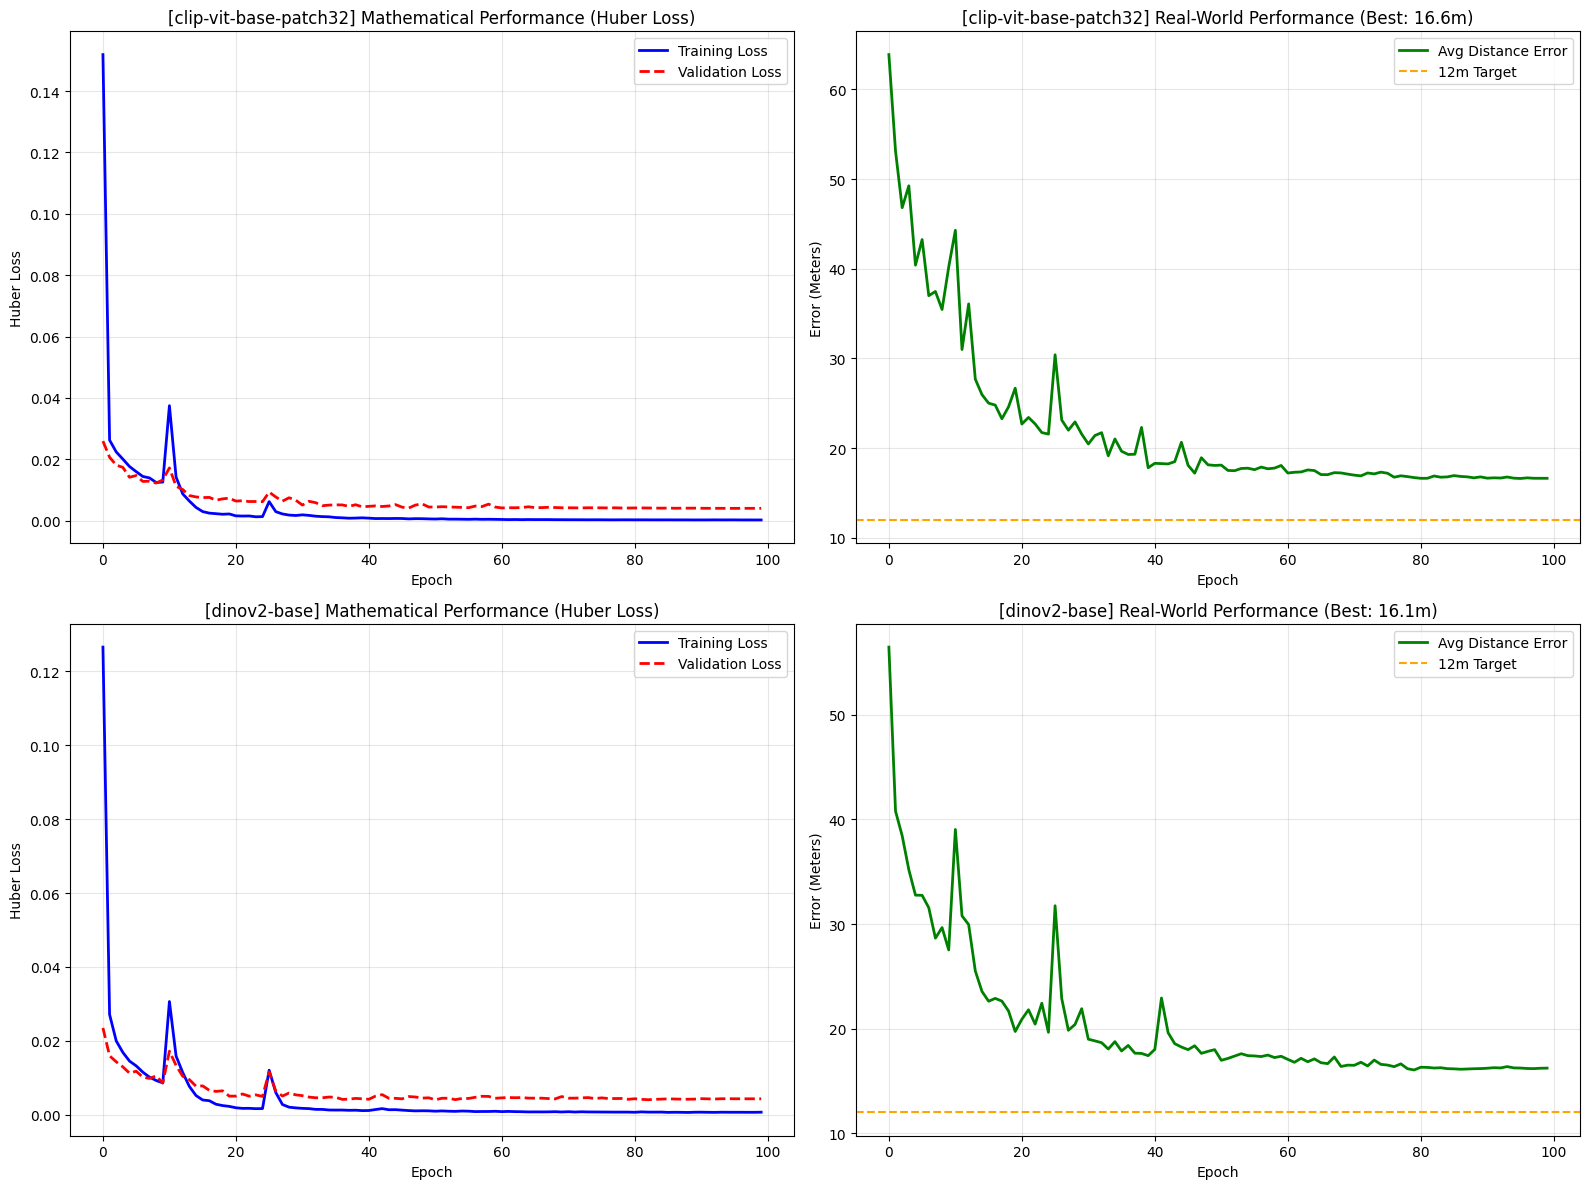

C:\Users\Tal Sch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


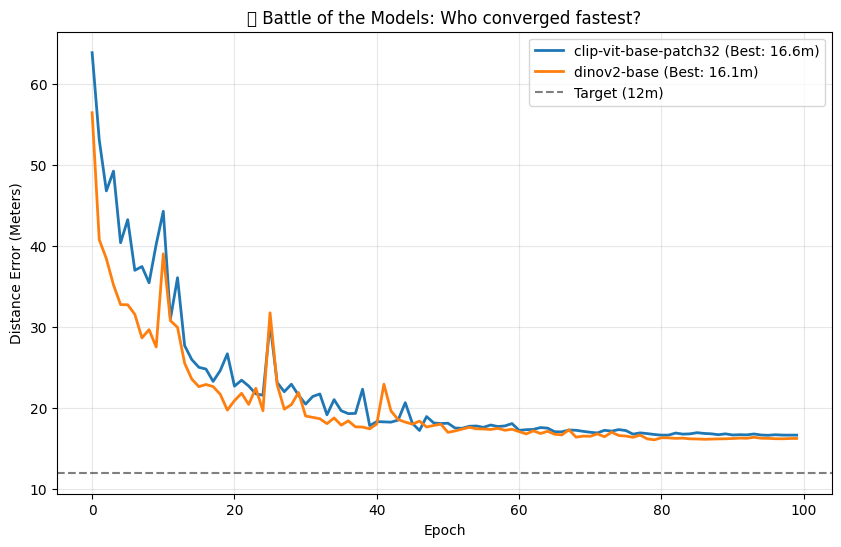

In [21]:
# ============================================================================
# 📊 ENSEMBLE TRAINING VISUALIZATION
# Run this cell after training completes.
# ============================================================================
import matplotlib.pyplot as plt

# 1. Setup the figure: One row for each model trained
n_models = len(all_histories)
fig, axes = plt.subplots(n_models, 2, figsize=(16, 6 * n_models))

# Handle the case of a single model (make axes iterable)
if n_models == 1: axes = [axes]

print(f"📈 Generating plots for {n_models} models...")

# 2. Iterate through each model's history
for idx, (model_name, history) in enumerate(all_histories.items()):
    
    # Get the specific axes for this row
    ax1 = axes[idx][0] if n_models > 1 else axes[0]
    ax2 = axes[idx][1] if n_models > 1 else axes[1]
    
    # --- PLOT 1: Huber LOSS (Left) ---
    ax1.plot(history['train_loss'], label="Training Loss", color="blue", linewidth=2)
    ax1.plot(history['val_loss'], label="Validation Loss", color="red", linestyle="--", linewidth=2)
    
    # Clean name for title (e.g., "openai/clip-rn50" -> "clip-rn50")
    clean_name = model_name.split("/")[-1]
    ax1.set_title(f"[{clean_name}] Mathematical Performance (Huber Loss)")
    
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Huber Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- PLOT 2: DISTANCE ERROR (Right) ---
    ax2.plot(history['dist_error'], label="Avg Distance Error", color="green", linewidth=2)
    ax2.axhline(y=12, color='orange', linestyle='--', label='12m Target')
    
    ax2.set_title(f"[{clean_name}] Real-World Performance (Best: {history['best_dist']:.1f}m)")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Error (Meters)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- OPTIONAL: SUMMARY COMPARISON ---
# This puts just the "Distance" lines of all 3 models on ONE graph for easy comparison
plt.figure(figsize=(10, 6))
for model_name, history in all_histories.items():
    clean_name = model_name.split("/")[-1]
    plt.plot(history['dist_error'], label=f"{clean_name} (Best: {history['best_dist']:.1f}m)", linewidth=2)

plt.axhline(y=12, color='black', linestyle='--', alpha=0.5, label='Target (12m)')
plt.title("🏆 Battle of the Models: Who converged fastest?")
plt.xlabel("Epoch")
plt.ylabel("Distance Error (Meters)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()